# Lights model tutorial

In [1]:
%reset -f
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from tick.plot import plot_point_process
from lights.simulation import SimuJointLongitudinalSurvival
from lights.base.utils import heatmap, annotate_heatmap, gompertz_pdf, \
                              gompertz_survival, visualize_vect_learning
from sklearn.model_selection import ShuffleSplit
from lifelines.utils import concordance_index as c_index_score
from IPython.display import Markdown, display
from scipy.stats import beta
from matplotlib import rc
rc('text', usetex=True)
%matplotlib inline

def printmd(string):
    display(Markdown(string))

## Generate data

In [2]:
n_long_features = 3
n_time_indep_features = 5
simu = SimuJointLongitudinalSurvival(seed=123, n_long_features=n_long_features, n_samples=400
                                     ,n_time_indep_features = n_time_indep_features)
X, Y, T, delta = simu.simulate()

printmd("\nLevel of censoring: **%.2f%%**" % (100*(1 - delta.mean())))

-----------------------------------------------------------
Launching simulation using SimuJointLongitudinalSurvival...
Done simulating using SimuJointLongitudinalSurvival in 1.35e+00 seconds.



Level of censoring: **39.00%**

### Visualize parameter vectors
We generate survival times with a risk model of the form
$$\begin{align*}
\lambda_i(t|G_i = k) &= \lambda_0(t) \exp \Big\{ x_i^\top \xi + \sum_{l=1}^L \gamma_{k,1}^l (\beta_{k,1}^l + \beta_{k,2}^l t + b_{i,1}^l + b_{i,2}^l t) + (\gamma_{k,2,1}^l b_{i,1}^l + \gamma_{k,2,2}^l b_{i,2}^l) + \gamma_{k,3}^l (\beta_{k,2}^l + b_{i,2}^l) \Big\} \\
&= \lambda_0(t) \exp \big\{ \iota_{i,k,1} + \iota_{i,k,2} t \big\}
\end{align*}$$

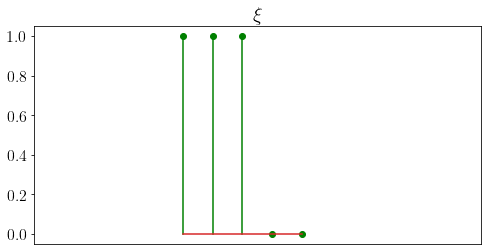

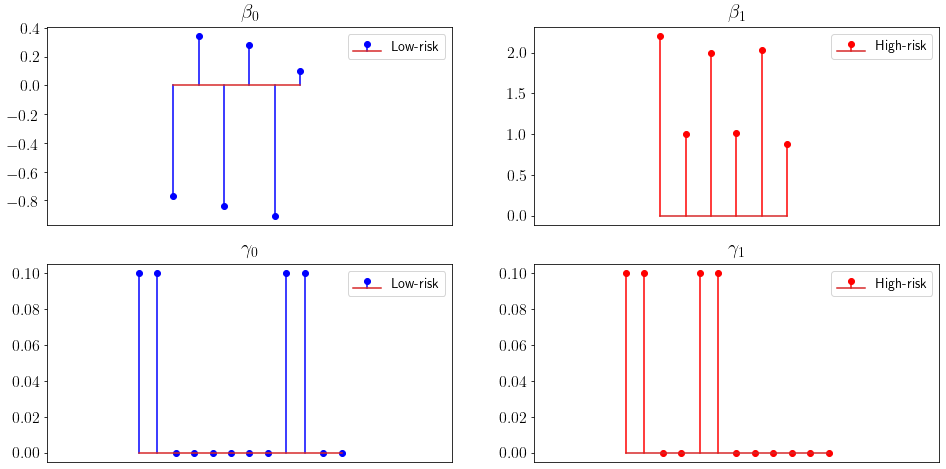

In [3]:
xi, betas, gammas = simu.time_indep_coeffs, simu.fixed_effect_coeffs, simu.asso_coeffs

fig = plt.figure(figsize=(8, 4))
fontsize = 16
ax = fig.add_subplot(111)
ax.stem(xi, linefmt='g-', markerfmt='go')
ax.set_xlim([-5, len(xi) + 5])
ax.set_title(r"$\xi$", fontsize=fontsize+4)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()

fig = plt.figure(figsize=(16, 8))
names, colors, labels = ['beta', 'gamma'], ['b', 'r'], ['Low-risk', 'High-risk']
j = 1

for i, vectors in enumerate([betas, gammas]):
    for k in [0, 1]:
        name = names[i]
        ax = fig.add_subplot(2,2,j)
        j += 1
        ax.stem(vectors[k], linefmt='%s-' % colors[k], 
                markerfmt='%so' % colors[k], label=labels[k])
        ax.set_xlim([-5, len(vectors[k]) + 5])
        ax.set_title(r"$\%s_%s$" % (name, k), fontsize=fontsize+4)
        plt.yticks(fontsize=fontsize)
        plt.tick_params(axis='x', bottom=False, labelbottom=False)
        plt.legend(fontsize=fontsize-2)
plt.show()

### Visualize simulated times

We choose a Gompertz distribution for the baseline, that is
$$\lambda_0(t) = \kappa_1 \kappa_2 \exp(\kappa_2t)$$
with $\kappa_1 > 0$ and $\kappa_2 \in R$ the scale and shape parameters respectively.

kappa_1=0.001, kappa_2=0.1


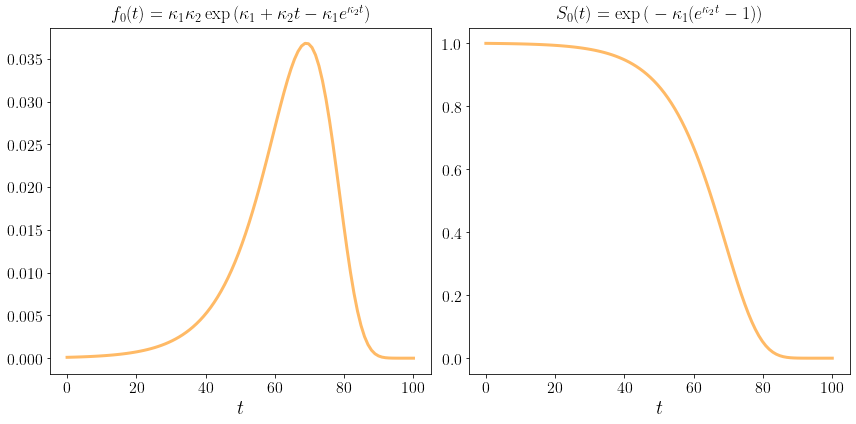

In [4]:
scale, shape = simu.scale, simu.shape
print("kappa_1=%s, kappa_2=%s" % (scale, shape))

fig = plt.figure(figsize=(12, 6))
# Density function plot
ax = fig.add_subplot(121)
t = np.linspace(0, 100, 100)
ax.plot(t, gompertz_pdf(t, shape, scale), '-', color='darkorange', lw=3, alpha=0.6)
plt.xlabel(r"$t$", fontsize=fontsize+4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title(r"$f_0(t) = \kappa_1 \kappa_2 \exp \big(\kappa_1 + \kappa_2 t -\kappa_1 e^{\kappa_2 t}\big)$", 
          size=fontsize+2)

# Survival function plot
ax = fig.add_subplot(122)
t = np.linspace(0, 100, 100)
ax.plot(t, gompertz_survival(t, shape, scale), '-', color='darkorange', lw=3, alpha=0.6)
plt.xlabel(r"$t$", fontsize=fontsize+4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title(r"$S_0(t) = \exp \big(-\kappa_1 (e^{\kappa_2 t} - 1) \big)$", size=fontsize+2)

fig.tight_layout()
plt.show()

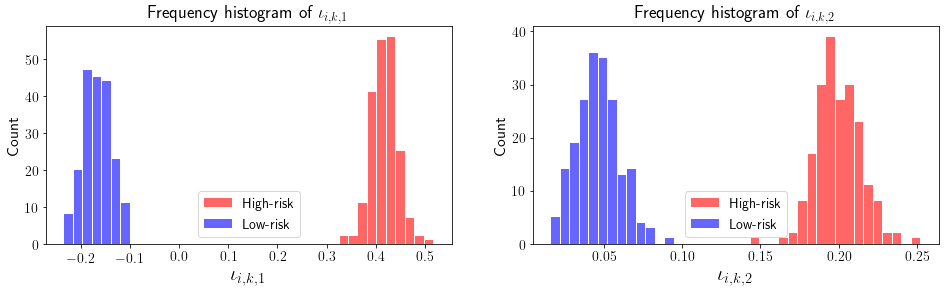

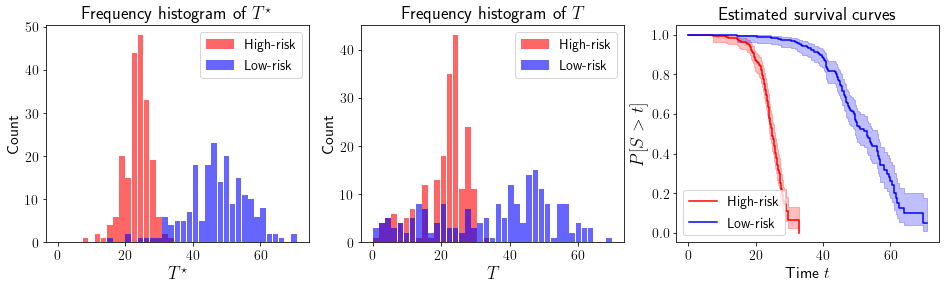

In [5]:
fig = plt.figure(figsize=(16, 4))
iotas = simu.iotas
for i in [1, 2]:
    ax = fig.add_subplot(1,2,i)
    iota_0i, iota_1i = iotas[i]
    all_iota = list(iota_0i) + list(iota_1i)
    mini, maxi = min(all_iota), max(all_iota)
    bins = np.linspace(mini, maxi, 40)
    kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
    plt.hist(iota_1i, **kwargs, color='r', label='High-risk')
    plt.hist(iota_0i, **kwargs, color='b', label='Low-risk')
    plt.xlabel(r"$\iota_{i,k,%s}$" % i, size=fontsize + 5)
    plt.ylabel("Count", size=fontsize)
    plt.legend(fontsize=fontsize-2)
    ax.tick_params(labelsize=fontsize-2)
    plt.title("Frequency histogram of " + r'$\iota_{i,k,%s}$' % i, size=fontsize+2)
plt.show()

fig = plt.figure(figsize=(16, 4))
G = simu.latent_class
T_star = simu.event_times
times, labels = [T_star, T], ['T^\star', 'T']
for i in [0, 1]:
    ax = fig.add_subplot(1,3,i+1)
    df = pd.DataFrame(data={"time": times[i], "group": G})
    bins = np.linspace(0, times[i].max(), 40)
    kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
    plt.hist(df.loc[df.group == 1, 'time'], **kwargs, color='r', label='High-risk')
    plt.hist(df.loc[df.group==0, 'time'], **kwargs, color='b', label='Low-risk')
    plt.legend(fontsize=fontsize-2)
    plt.xlabel(r'$%s$' % labels[i], size=fontsize+2)
    plt.ylabel("Count", size=fontsize)
    ax.tick_params(labelsize=fontsize-2)
    plt.title("Frequency histogram of " + r'$%s$' % labels[i], size=fontsize+2)

# Kaplan Meier estimation of survival curves
kmf = KaplanMeierFitter()
ax = plt.subplot(133)
kmf.fit(T_star[G == 1], delta[G == 1], label="High-risk").plot(ax=ax, c='r')
kmf.fit(T_star[G == 0], delta[G == 0], label="Low-risk").plot(ax=ax, c='b')
plt.legend(fontsize=fontsize-2)
plt.xlabel('Time $t$', size=fontsize)
plt.ylabel(r'$P[S > t]$', size=fontsize+2)
plt.title("Estimated survival curves", size=fontsize+2)
ax.tick_params(labelsize=fontsize-2)
plt.show()

### Visualize longitudinal processes for two subjects randomly chosen

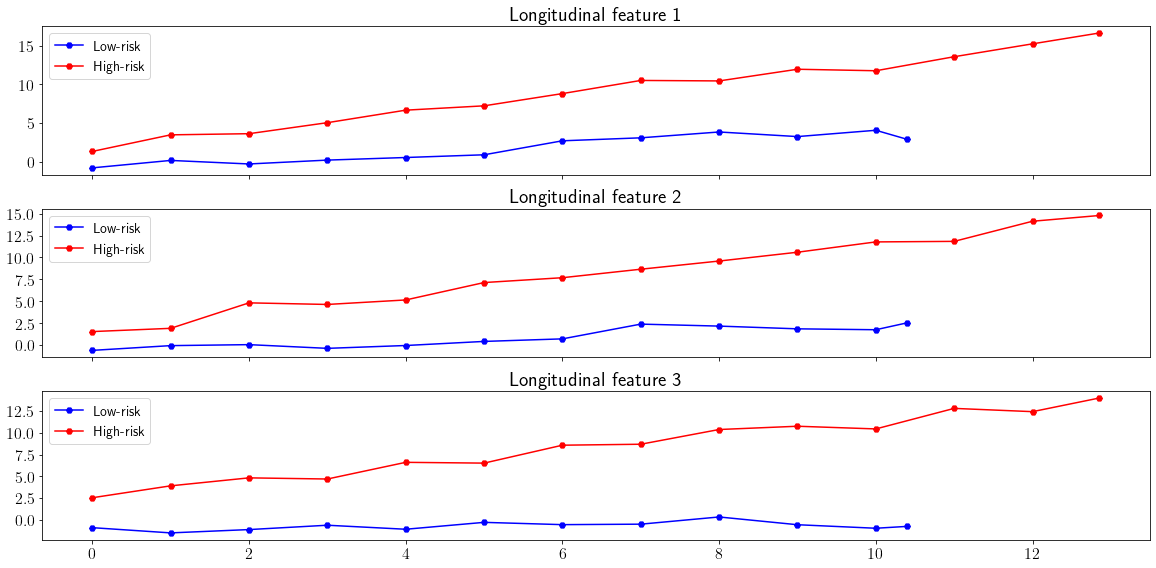

In [6]:
np.random.seed(10)
fig = plt.figure(figsize=(16, 8))
ax0 = plt.subplot(n_long_features,1,1)
colors, labels = ['b', 'r'], ['Low-risk', 'High-risk']
for k in [0, 1]:
    idx = np.random.choice(Y[G == k].index)
    Y_i = Y.loc[idx, :]
    label, color = labels[k], colors[k]
    for l in range(1, n_long_features + 1):
        Y_il = Y_i["long_feature_%s" % l]
        ax = plt.subplot(n_long_features,1 ,l , sharex=ax0)
        Y_il.plot(label=label, color=color, marker='H')
        ax.set_title("Longitudinal feature %s" % l, fontsize=fontsize+4)
        plt.xticks(fontsize=fontsize), plt.yticks(fontsize=fontsize)
        plt.legend(fontsize=fontsize-2)
fig.tight_layout()
plt.show()

# Lights learning

## Initializer illustration

Since our QNMCEM algorithm gives a local minimum, it is clever to choose an initial value $\theta^{(0)}$ close to the final solution $\hat \theta$, so that the number of iterations required to reach convergence is reduced.

The longitudinal submodels parameters $\beta_k^{(0)}$, $D^{(0)}$ and $\phi^{(0)}$ are initialized (like if there is no subgroup ($\beta_0^{(0)} = \beta_{1}^{(0)}$)) using a multivariate linear mixed model (MLMM) with an explicit EM algorithm, being itself initialized with univariates fits (ULMM). Let us test those initializer on a simple example.

### Simulation with no latent subgroups

In [7]:
from lights.init.mlmm import MLMM
from lights.base.base import extract_features
from lights.base.utils import plot_history

# high_risk_rate=0 for no subgroups
simu_ = SimuJointLongitudinalSurvival(n_samples=300, n_time_indep_features=5, n_long_features=3, 
                                      seed=1, high_risk_rate=0, fixed_effect_mean_low_risk=(1, .3),
                                      fixed_effect_mean_high_risk=(1, .5))
Y_ = simu_.simulate()[1]
# Get true beta parameter
true_beta_ = simu_.fixed_effect_coeffs[0]

-----------------------------------------------------------
Launching simulation using SimuJointLongitudinalSurvival...
Done simulating using SimuJointLongitudinalSurvival in 1.01e+00 seconds.


### MLMM with fixed initialization

For instance $\beta^{(0)}=\textbf{0}$

Launching the solver MLMM...
 n_iter  |   obj    | rel_obj 
       0 |  26340.5 |      inf
      10 |    18203 | 7.16e-05
      20 |  18196.1 | 2.85e-05
      30 |  18191.4 | 2.39e-05
      40 |  18187.3 | 2.22e-05
      50 |  18183.4 | 2.10e-05
      60 |  18179.6 | 2.00e-05
      70 |  18176.1 | 1.91e-05
      80 |  18172.7 | 1.82e-05
      90 |  18169.5 | 1.74e-05
     100 |  18166.4 | 1.66e-05
     110 |  18163.5 | 1.58e-05
     120 |  18160.7 | 1.50e-05
     130 |    18158 | 1.43e-05
     140 |  18155.5 | 1.36e-05
     150 |  18153.1 | 1.29e-05
     160 |  18150.8 | 1.23e-05
     170 |  18148.7 | 1.17e-05
     180 |  18146.6 | 1.11e-05
     190 |  18144.7 | 1.05e-05
     200 |  18142.8 | 1.00e-05
Done solving using MLMM in 8.64e+01 seconds


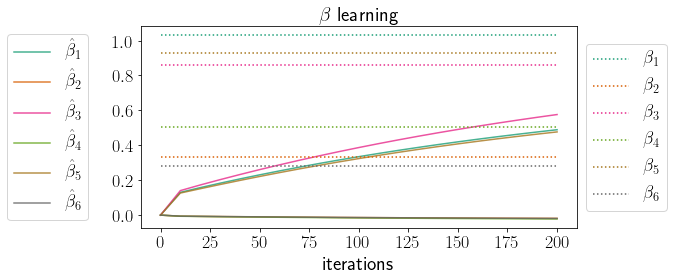

In [8]:
fixed_effect_time_order = 1
tol = 1e-5
mlmm = MLMM(fixed_effect_time_order=fixed_effect_time_order, 
            tol=tol, initialize=False, max_iter=300)
# Get design features matrices
extracted_features = extract_features(Y_, fixed_effect_time_order)
# Train the initializer
mlmm.fit(extracted_features)

# Visualize learning
to = len(true_beta_)+1
leg1 = [r"$\hat \beta_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta_%s$" % j for j in range(1, to)]
visualize_vect_learning(mlmm, "fixed_effect_coeffs", r"$\beta$", true_beta_, leg1, leg2)

### MLMM with ULMM initialization

<span style="color:crimson">**Convergence is faster, and the estimation much better**</span>

Launching the solver MLMM...
Launching the solver ULMM...


/Users/acsi/Working/lights/.env/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/acsi/Working/lights/.env/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Done solving using ULMM in 2.05e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |  18074.7 |      inf
       5 |  17533.5 | 3.17e-04
      10 |  17523.8 | 5.32e-05
      15 |  17521.3 | 1.78e-05
Done solving using MLMM in 1.04e+01 seconds


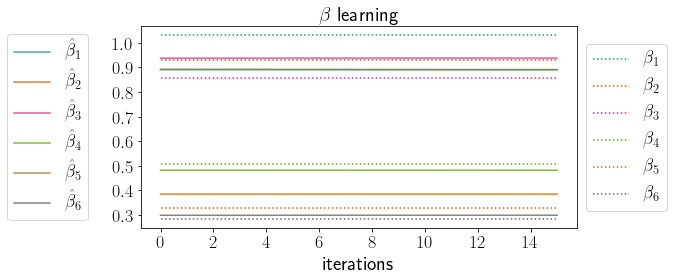

In [9]:
mlmm = MLMM(fixed_effect_time_order=fixed_effect_time_order, 
            print_every=5, tol=tol, initialize=True)
extracted_features = extract_features(Y_, fixed_effect_time_order)
mlmm.fit(extracted_features)
visualize_vect_learning(mlmm, "fixed_effect_coeffs", r"$\beta$", true_beta_, leg1, leg2)

In [10]:
# True covariance of random effect
true_long_cov = simu.long_cov
print("True of covariance of random effect", true_long_cov)
# Estimation of covariance of random effect
est_long_cov = mlmm.long_cov
print("Estimatation of covariance of random effect", est_long_cov)

True of covariance of random effect [[1.e-02 1.e-05 1.e-08 1.e-11 1.e-14 1.e-17]
 [1.e-05 1.e-02 1.e-05 1.e-08 1.e-11 1.e-14]
 [1.e-08 1.e-05 1.e-02 1.e-05 1.e-08 1.e-11]
 [1.e-11 1.e-08 1.e-05 1.e-02 1.e-05 1.e-08]
 [1.e-14 1.e-11 1.e-08 1.e-05 1.e-02 1.e-05]
 [1.e-17 1.e-14 1.e-11 1.e-08 1.e-05 1.e-02]]
Estimatation of covariance of random effect [[ 2.41558771e-02 -3.09095307e-03 -1.40187822e-02  2.74906280e-03
   6.14147400e-03  3.78895297e-04]
 [-3.09095307e-03  1.01937178e-02  4.82058250e-03 -9.38877048e-04
  -2.16361764e-03 -9.38714616e-06]
 [-1.40187822e-02  4.82058250e-03  2.93051901e-02 -5.58604343e-03
  -6.84975479e-03  1.14834968e-03]
 [ 2.74906280e-03 -9.38877048e-04 -5.58604343e-03  1.11813760e-02
   3.98014846e-03 -1.30457417e-03]
 [ 6.14147400e-03 -2.16361764e-03 -6.84975479e-03  3.98014846e-03
   1.71388147e-02 -9.46784549e-04]
 [ 3.78895297e-04 -9.38714616e-06  1.14834968e-03 -1.30457417e-03
  -9.46784549e-04  1.03338909e-02]]


## Data splitting

In [11]:
# Split data into training and test sets 
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

for train_index, test_index in rs.split(X):
    X_test = X[test_index]
    Y_test = Y.iloc[test_index, :]
    T_test = T[test_index]
    delta_test = delta[test_index]

    X_train = X[train_index]
    Y_train = Y.iloc[train_index, :]
    T_train = T[train_index]
    delta_train = delta[train_index]
    
print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

70% for training, 30% for testing.


## Training 

In [12]:
from lights.inference import QNMCEM

## Choose parameters ##
tol = 1e-6            # tolerance for the convergence stopping criterion 
eta = 0.3             # parameter controlling the trade-off between l1 
                      # and l2 regularization in the elasticNet
gamma_chosen = '1se'  # way to select l_elasticNet_chosen: '1se' or 'min'
warm_start = True     # at each L-BGFS-B iteration, reset beta to 0 or take 
                      # the previous value 
grid_size = 30        # grid size for the cross validation procedure
metric = 'C-index'    # cross-validation metric: 'log_lik' or 'C-index'

qnmcem = QNMCEM(fixed_effect_time_order=1, max_iter=20, compute_obj=True, print_every=1,
               l_pen_SGL=0.2, eta_sp_gp_l1=.3, asso_functions=["lp", "re", "tps"],
               l_pen_EN=0.01, initialize=True)
qnmcem.fit(X_train, Y_train, T_train, delta_train)

# Visualize learning
visualize_vect_learning(qnmcem, "obj")

Launching the solver QNMCEM...
Launching the solver MLMM...
Launching the solver ULMM...


/Users/acsi/Working/lights/.env/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/acsi/Working/lights/.env/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/acsi/Working/lights/.env/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Done solving using ULMM in 1.58e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |  17897.6 |      inf
       1 |  15924.1 | 1.10e-01
       2 |  15730.6 | 1.21e-02
       3 |    15695 | 2.26e-03
       4 |  15681.2 | 8.83e-04
       5 |    15674 | 4.57e-04
       6 |  15669.7 | 2.73e-04
       7 |  15666.9 | 1.79e-04
       8 |    15665 | 1.25e-04
       9 |  15663.5 | 9.13e-05
      10 |  15662.5 | 6.90e-05
      11 |  15661.6 | 5.37e-05
      12 |    15661 | 4.26e-05
      13 |  15660.4 | 3.45e-05
      14 |    15660 | 2.83e-05
      15 |  15659.6 | 2.36e-05
      16 |  15659.3 | 1.99e-05
      17 |    15659 | 1.69e-05
      18 |  15658.8 | 1.45e-05
      19 |  15658.6 | 1.26e-05
      20 |  15658.4 | 1.10e-05
Done solving using MLMM in 8.59e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |      inf |      inf


KeyboardInterrupt: 

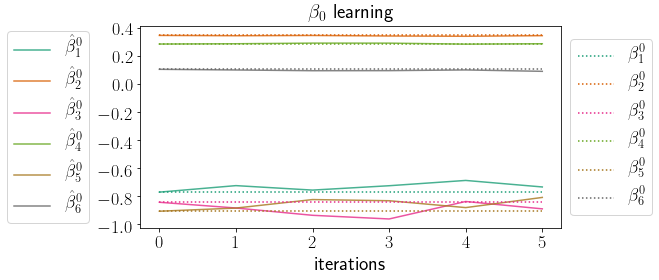

In [13]:
# Visualize beta_0
true_beta_0 = simu.fixed_effect_coeffs[0].reshape(-1, 1)
to = len(true_beta_0)+1
leg1 = [r"$\hat \beta^0_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta^0_%s$" % j for j in range(1, to)]
visualize_vect_learning(qnmcem, "beta_0", r"$\beta_0$", true_beta_0, leg1, leg2)

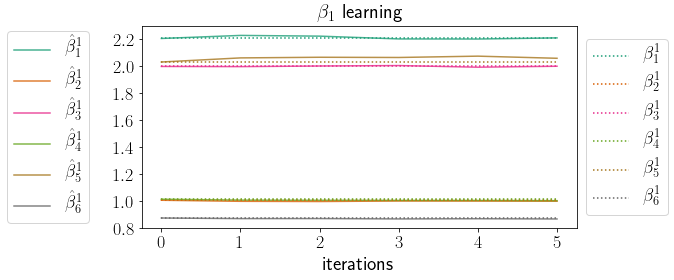

In [14]:
# Visualize beta_1
true_beta_1 = simu.fixed_effect_coeffs[1].reshape(-1, 1)
to = len(true_beta_1)+1
leg1 = [r"$\hat \beta^1_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta^1_%s$" % j for j in range(1, to)]
visualize_vect_learning(qnmcem, "beta_1", r"$\beta_1$", true_beta_1, leg1, leg2)

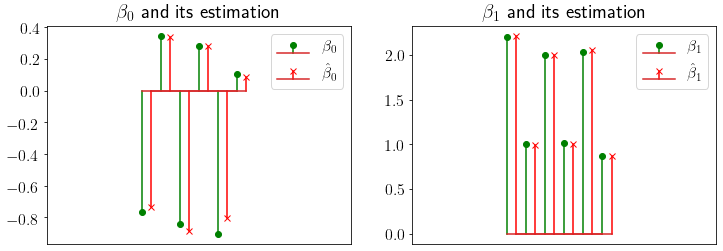

In [15]:
beta_0_true = true_beta_0
beta_0_est = qnmcem.theta["beta_0"]
fig = plt.figure(figsize=(12, 4))
fontsize = 16
ax = fig.add_subplot(121)
ax.stem(np.arange(len(beta_0_true)).tolist(), beta_0_true, linefmt='g-', markerfmt='go', label= r"$\beta_0$")
ax.stem((np.arange(len(beta_0_est)) + .5).tolist(), beta_0_est, linefmt='r-', markerfmt='rx', label= r"$\hat \beta_0$")
ax.set_xlim([-5, len(beta_0_true) + 5])
ax.set_title(r"$\beta_0$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)

beta_1_true = true_beta_1
beta_1_est = qnmcem.theta["beta_1"]
fontsize = 16
ax = fig.add_subplot(122)
ax.stem(np.arange(len(beta_1_true)).tolist(), beta_1_true, linefmt='g-', markerfmt='go', label= r"$\beta_1$")
ax.stem((np.arange(len(beta_1_est)) + .5).tolist(), beta_1_est, linefmt='r-', markerfmt='rx', label= r"$\hat \beta_1$")
ax.set_xlim([-5, len(beta_1_true) + 5])
ax.set_title(r"$\beta_1$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()

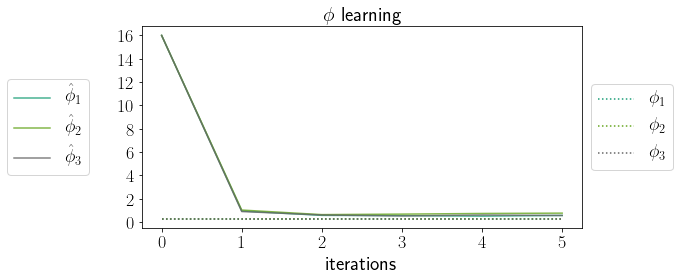

In [16]:
# Visualize phi
true_phi = np.array([simu.std_error ** 2] * simu.n_long_features).reshape(-1, 1)
to = len(true_phi)+1
leg1 = [r"$\hat \phi_%s$" % j for j in range(1, to)]
leg2 = [r"$\phi_%s$" % j for j in range(1, to)]
visualize_vect_learning(qnmcem, "phi", symbol = r"$\phi$", true_coeffs = true_phi, legend_est = leg1, legend_true = leg2)

In [17]:
qnmcem.history.values["phi"]

[array([16., 16., 16.]),
 array([0.93606459, 1.01589165, 0.88639348]),
 array([0.55913257, 0.62375326, 0.59235772]),
 array([0.53887843, 0.66664844, 0.51399698]),
 array([0.49529817, 0.72181855, 0.59056291]),
 array([0.55003685, 0.75063037, 0.55167168])]

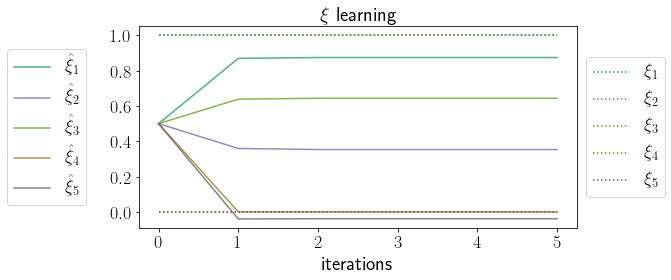

In [18]:
# Visualize xi
true_xi = simu.time_indep_coeffs.reshape(-1, 1)
to = len(true_xi)+1
leg1 = [r"$\hat \xi_%s$" % j for j in range(1, to)]
leg2 = [r"$\xi_%s$" % j for j in range(1, to)]
visualize_vect_learning(qnmcem, "xi", r"$\xi$", true_xi, leg1, leg2)

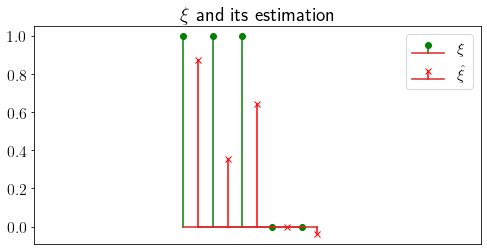

In [19]:
xi_true = true_xi
xi_est = qnmcem.theta["xi"]
fig = plt.figure(figsize=(8, 4))
fontsize = 16
ax = fig.add_subplot(111)
ax.stem(np.arange(len(xi_true)).tolist(), true_xi, linefmt='g-', markerfmt='go', label= r"$\xi$")
ax.stem((np.arange(len(xi_est)) + .5).tolist(), xi_est, linefmt='r-', markerfmt='rx', label= r"$\hat \xi$")
ax.set_xlim([-5, len(true_xi) + 5])
ax.set_title(r"$\xi$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()

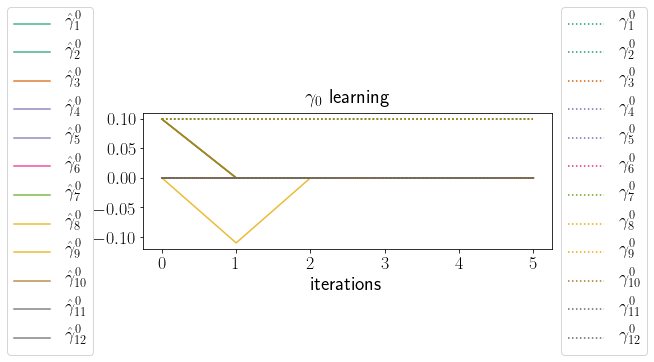

In [20]:
# Visualize gamma_0
true_gamma_0 = simu.asso_coeffs[0].reshape(-1, 1)
to = len(true_gamma_0)+1
leg1 = [r"$\hat \gamma^0_{%s}$" % j for j in range(1, to)]
leg2 = [r"$\gamma^0_{%s}$" % j for j in range(1, to)]
visualize_vect_learning(qnmcem, "gamma_0", r"$\gamma_0$", true_gamma_0, leg1, leg2)

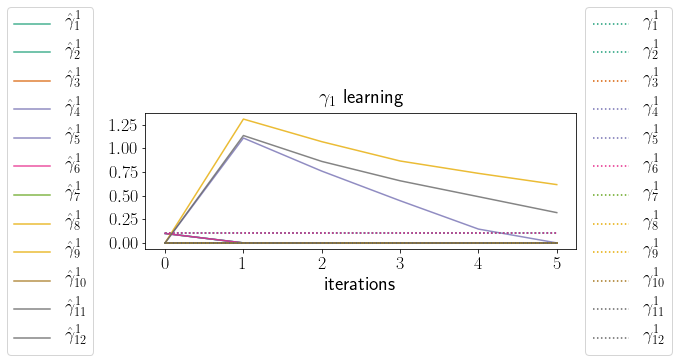

In [21]:
# Visualize gamma_1
true_gamma_1 = simu.asso_coeffs[1].reshape(-1, 1)
to = len(true_gamma_1)+1
leg1 = [r"$\hat \gamma^1_{%s}$" % j for j in range(1, to)]
leg2 = [r"$\gamma^1_{%s}$" % j for j in range(1, to)]
visualize_vect_learning(qnmcem, "gamma_1", r"$\gamma_1$", true_gamma_1, leg1, leg2)

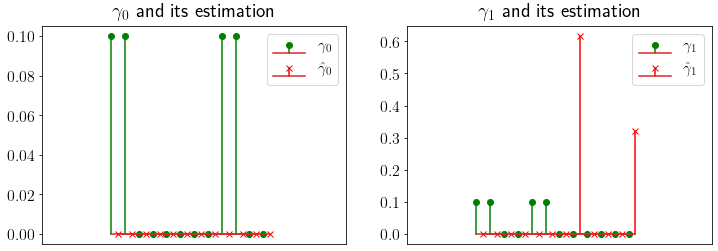

In [22]:
gamma_0_true = true_gamma_0
gamma_0_est = qnmcem.theta["gamma_0"]
fig = plt.figure(figsize=(12, 4))
fontsize = 16
ax = fig.add_subplot(121)
ax.stem(np.arange(len(gamma_0_true)).tolist(), gamma_0_true, linefmt='g-', markerfmt='go', label= r"$\gamma_0$")
ax.stem((np.arange(len(gamma_0_est)) + .5).tolist(), gamma_0_est, linefmt='r-', markerfmt='rx', label= r"$\hat \gamma_0$")
ax.set_xlim([-5, len(true_gamma_0) + 5])
ax.set_title(r"$\gamma_0$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)

gamma_1_true = true_gamma_1
gamma_1_est = qnmcem.theta["gamma_1"]
ax = fig.add_subplot(122)
ax.stem(np.arange(len(gamma_1_true)).tolist(), gamma_1_true, linefmt='g-', markerfmt='go', label= r"$\gamma_1$")
ax.stem((np.arange(len(gamma_1_est)) + .5).tolist(), gamma_1_est, linefmt='r-', markerfmt='rx', label= r"$\hat \gamma_1$")
ax.set_xlim([-5, len(true_gamma_1) + 5])
ax.set_title(r"$\gamma_1$ and its estimation", fontsize=fontsize+4)
plt.legend(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()

In [23]:
# Check estimated covariance of random effect
qnmcem.theta["long_cov"]

array([[ 1.11580243e-02, -2.05667000e-03, -1.25580188e-03,
        -4.55899134e-03, -5.60665814e-03, -3.10076900e-03],
       [-2.05667000e-03,  8.13479094e-03,  3.52545861e-04,
        -2.18722061e-04, -1.06246122e-03, -1.23488134e-04],
       [-1.25580188e-03,  3.52545861e-04,  5.19043109e-03,
         9.68472949e-04,  1.10979354e-03, -2.38671602e-03],
       [-4.55899134e-03, -2.18722061e-04,  9.68472949e-04,
         4.85481715e-03,  2.75896788e-03, -9.94226488e-05],
       [-5.60665814e-03, -1.06246122e-03,  1.10979354e-03,
         2.75896788e-03,  1.25641325e-02,  4.36559222e-03],
       [-3.10076900e-03, -1.23488134e-04, -2.38671602e-03,
        -9.94226488e-05,  4.36559222e-03,  7.80231977e-03]])

<function matplotlib.pyplot.show(*args, **kw)>

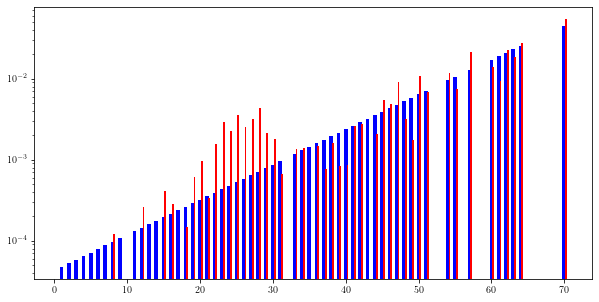

In [24]:
times = qnmcem.theta["baseline_hazard"].index.values
est_value = qnmcem.theta["baseline_hazard"].values
true_value = (simu.scale * simu.shape) * np.exp(simu.shape * times)
non_zero_idx = np.argwhere(est_value != 0)
ratio = np.mean(true_value[non_zero_idx] / est_value[non_zero_idx])
fig = plt.figure(figsize=(10, 5))
plt.bar(times, np.log10(1 + true_value), color = 'b', width = 0.5)
plt.bar(times + 0.25, np.log10(1 + est_value * ratio), color = 'r', width = 0.25)
plt.yscale('log')
plt.show

### Note
* Currently, for debugging phase, just run first two cells and move to "Training" cell to run QNMCEM algorithm
* Call the QNMCEM function to run experiments with different setting (l_pen, max_iter, copt_accelerate, ...)

## Prediction

In [25]:
# evalutation here
marker_train = qnmcem.predict_marker(X_train, Y_train)
c_index_train = c_index_score(T_train, marker_train, delta_train)
c_index_train = max(c_index_train, 1 - c_index_train)

## Obtain the marker vector on test set ##

# prediction here
marker_test = qnmcem.predict_marker(X_test, Y_test)
c_index_test = c_index_score(T_test, marker_test, delta_test)
c_index_test = max(c_index_test, 1 - c_index_test)

print("Done predicting on dataset.")
print("C-index on train: %.2f" % c_index_train)
print("C-index on test: %.2f" % c_index_test)

Done predicting on dataset.
C-index on train: 0.76
C-index on test: 0.75


## Figures

### Learning curves

### Convergence

### Beta coefficients